# Figure 14
Responses obtained by placing the transmitter and receiver in separate tunnels.

In [ ]:
from SimPEG import  maps, utils
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
import empymod
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import animation, collections

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

import sys

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('bmh')

/tmp/ipykernel_14442/2016789560.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import  maps, utils


## Create a Tensor Mesh

In [2]:
# setting the loop location
def get_loop_location(length, angle, offset, loc):

    """
    Get the loop location based on the length and angle
    """
    delta = offset / 2
    locations = []

    # if angle < 90:
    x = length / 2
    y = (length / 2) * np.sin(np.deg2rad(angle)) + loc + 2
    z = 2 #(length / 2) * np.cos(np.deg2rad(angle))

    locations.append([-delta-x, y,  z])
    locations.append([-delta+x, y,  z])
    locations.append([-delta+x, y, -z])
    locations.append([-delta-x, y, -z])
    locations.append([-delta-x, y,  z])

    return np.array(locations)


In [3]:
def mesh_d(cell, tunnel_length, depth, dir, distance, line_length, loop_length, src_type):
    '''
    length: the length of the loop
    angle: the measured angle of the loop
    dir: the abnormal body direction
    distance: the distance between the two tunnels
    '''
    dh = cell  # base cell width
    y_d = [-distance / 2, distance / 2]

    # dom_width = 5000.0  # domain width
    dom_width = 10000
    nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

    # Define the base mesh
    h = [(dh, nbc)]
    mesh = TreeMesh([h, h, h], x0="CCC")

    n = tunnel_length / 2
    for j in range(len(y_d)):
        for i in range(int(tunnel_length)):
            x_low = -n + i + 0.1 
            # ——————————————————————————y-left——————————————————————————————————
            xp, yp, zp = np.meshgrid([x_low], [-2.5 + y_d[j], -2.3 + y_d[j]], [-2.5, 2.5])
            xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
            mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

            # ——————————————————————————y-right——————————————————————————————————
            xp, yp, zp = np.meshgrid([x_low], [2.4 + y_d[j], 2.6 + y_d[j]], [-2.5, 2.5])
            xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
            mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

            # ——————————————————————————z-upper——————————————————————————————————
            xp, yp, zp = np.meshgrid([x_low], [-2.5 + y_d[j], 2.5 + y_d[j]], [2.4, 2.5])
            xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
            mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # # ——————————————————————————z-lower——————————————————————————————————
        xp, yp, zp = np.meshgrid([-n, n], [-0.7 + y_d[j]], [-2.4, -2.3])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        xp, yp, zp = np.meshgrid([-n, n], [0.7 + y_d[j]], [-2.4, -2.3])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    if src_type == 'loop':
        source_locations = get_loop_location(loop_length, 0, 0, y_d[0])
        receiver_locations = np.array([[0, y_d[1]-2, 0]])

    elif src_type == 'line':
        receiver_locations = np.array([[0, -2.5 - depth + y_d[1], 0]])
        source_locations = np.array([[-line_length/2, 2.5 + depth + y_d[0], 0], [line_length/2, 2.5 + depth + y_d[0], 0]])

    else:
        print("请设置正确的源类型！")

    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
    )
    # # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, source_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    # # ——————————————————————————异常体区域加密——————————————————————————————————
    if dir == 1:
        x1, y1, z1 = 0, 0, 0
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 2:
        x1, y1, z1 = 0, 0, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    else:
        print('error')
        return 0
    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, abnormal_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    mesh.finalize()

    return mesh, source_locations, receiver_locations, abnormal_locations[0]

In [4]:
def get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block, sigma_air, center, tunnel_length, distance):
    thickness = 0.2
    y_d = [-distance / 2, distance / 2]
    model = np.ones(mesh.nC) * sigma_half
    mur = np.ones(mesh.nC)

    for j in range(len(y_d)):
        n = int(tunnel_length/2)
        ################layer####################
        layer = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                (mesh.gridCC[:,1] >= -2.5+y_d[j]) & (mesh.gridCC[:,1] <= 2.5+y_d[j]) &
                (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))

        rail1 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                (mesh.gridCC[:,1] >= -0.8+y_d[j]) & (mesh.gridCC[:,1] <= -0.8 + thickness+y_d[j]) &
                (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))

        rail2 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                (mesh.gridCC[:,1] >= 0.8 - thickness+y_d[j]) & (mesh.gridCC[:,1] <= 0.8+y_d[j]) &
                (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))
        model[layer] = sigma_air
        mur[layer] = 1  


        ################ interference ####################
        for i in range(int(tunnel_length)):
            layer_1 =   ((mesh.gridCC[:,0] >= -n+i) & (mesh.gridCC[:,0] <= -n+i+thickness) & 
                        (mesh.gridCC[:,1] >= -2.5+y_d[j]) & (mesh.gridCC[:,1] <= 2.5+y_d[j]) &
                        (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))
            
            model[layer_1] = sigma_frame
            mur[layer_1] = mu_r


        layer_2 =   ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                        (mesh.gridCC[:,1] >= -2.5 + thickness+y_d[j]) & (mesh.gridCC[:,1] <= 2.5 - thickness+y_d[j]) &
                        (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5 - thickness))
        model[layer_2] = sigma_air
        mur[layer_2] = 1


        model[rail1] = sigma_rail
        model[rail2] = sigma_rail
        mur[rail1] = mu_r
        mur[rail2] = mu_r
    
    ################ abnormal ####################
    block = (
        (mesh.gridCC[:,0] >= center[0]-25) & (mesh.gridCC[:,0] <= center[0]+25) & 
        (mesh.gridCC[:,1] >= center[1]-25) & (mesh.gridCC[:,1] <= center[1]+25) & 
        (mesh.gridCC[:,2] >= center[2]-25) & (mesh.gridCC[:,2] <= center[2]+25))
    model[block] = sigma_block

    fig = plt.figure(figsize=(10,10), dpi=100)
    plt.subplot(221)
    plt.rcParams["font.family"] = ["Times New Roman"]
    ax = plt.gca()
    # mesh.plot_3d_slicer(np.log10(model), zslice = 0, fig=fig, 
    #                     xlim=[-10, 10], ylim=[-10, 10], zlim=[-10, 10],
    #                     )
    dat2 = mesh.plotSlice(np.log10(model), grid= True , ax=ax, normal='x',lw=0.5)
#     ax.grid(linewidth=2)  # 设置网格线的粗细为2
#     ax.set_xlim([-100,100])
#     ax.set_ylim([-100,100])
    ax.set_xlim([-3+y_d[0],3+y_d[0]])
    ax.set_ylim([-3,3])
    ax.set_title("Conductivity profile at X = 0")
    ax.set_xlabel("Y / m", fontsize=12)
    ax.set_ylabel("Z / m", fontsize=12)
    ax.tick_params(labelsize=12)

    plt.subplot(222)
    ax = plt.gca()
    dat2 = mesh.plotSlice(np.log10(model), grid= True , ax=ax,  normal='x')
    ax.set_xlim([-3+y_d[1],3+y_d[1]])
    ax.set_ylim([-3,3])
    ax.set_title("Conductivity profile at X = 0")
    ax.set_xlabel("Y / m", fontsize=12)
    ax.set_ylabel("Z / m", fontsize=12)
    ax.tick_params(labelsize=12)

    return model, mur

In [5]:
def forward(mesh, model, mur, source_locations, receiver_locations, path, src_type):
    times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)
    rec_list = []
    time_steps =  [1e-7, (1e-7,21), (3e-7,21), (1e-6,21), (3e-6,21), (1e-5, 21), (3e-5, 11),(1e-4, 11), (3e-4, 11),(1e-3, 11)]

    if src_type == 'line':
        rec_list = []
        # Set up the receiver list
        for i in ["x", "y", "z"]:
            rec_list.append(tdem.Rx.PointElectricField(
                    orientation=i,
                    times=times,
                    locations=receiver_locations[0]
                ))

        # Set up the source list
        src_list = [
            tdem.Src.LineCurrent(
                receiver_list=rec_list,
                location=np.array([source_locations[0], source_locations[1]]),
            ),
        ]

        # Create `Survey`
        survey = tdem.Survey(src_list)

        # Define the `Simulation`
        prob = tdem.Simulation3DElectricField(
            mesh,
            survey=survey,
            sigmaMap=maps.IdentityMap(mesh),
            solver=Solver,
            time_steps=time_steps,
            verbose = True
        )

    elif src_type == 'loop':
        for i in ["x", "y", "z"]:
            rec_list.append(tdem.Rx.PointMagneticFluxTimeDerivative(
                        orientation = i,
                        times=times,
                        locations=receiver_locations[0])
                        )

        # Set up the source list
        src_list = [
            tdem.Src.LineCurrent(
                receiver_list=rec_list,
                location=source_locations,
            ),
        ]

        # Create `Survey`
        survey = tdem.Survey(src_list)

        # Define the `Simulation`
        prob = tdem.Simulation3DElectricField(
            mesh,
            survey=survey,
            sigmaMap=maps.IdentityMap(mesh),
            solver=Solver,
            time_steps=time_steps,
            verbose = True
        )
    else:
        print('请设置正确的源类型!')
        
    # Run the forward simulation
    prob.mu = mur*mu_0
    dpred = prob.dpred(model)

    np.save(path, dpred)
    # np.save("./data_offset/dobs_offset{}m_noBlock.npy".format(d),dpred)

In [6]:
def effective_conductivity(sigma_steel, sigma_back, S_steel, S_cell):
    #sigma_real * A_real / A_eff
    sigma_eff = sigma_steel * (S_steel / S_cell) + sigma_back * (S_cell - S_steel) / S_cell
    return sigma_eff

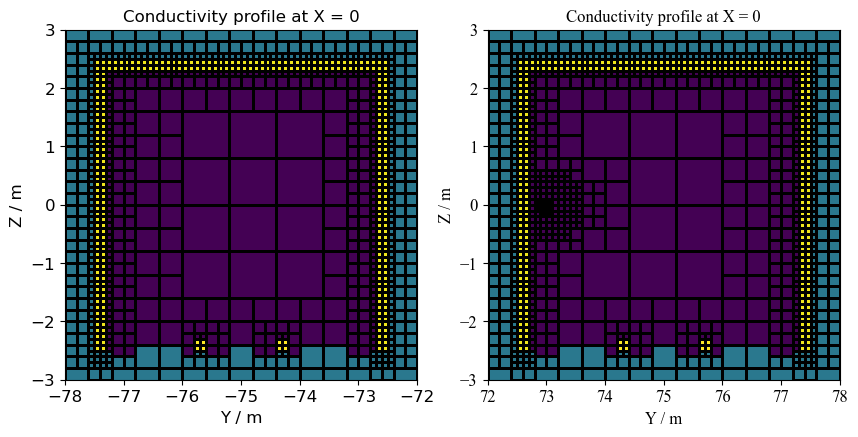

In [7]:
sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 100
sigma_frame = effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
sigma_rail  = effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2]   # 异常体的方位
depth = [0, 0.5, 1, 2]
src_length = [1, 5, 10, 20]
src_type = ['loop', 'line']
distance = 150
loop_length = [1, 10, 20, 30, 50]

i= 0
j=0
path = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m.npy".format(
    src_type[j],
    sigma_block[i], 
    src_length[-1],
    tunnel_length[0],
    dir[0],
    distance)

mesh, source_locations, receiver_locations, center = mesh_d(cell[0], tunnel_length[0], 
                                                            depth[1], dir[0], distance, 
                                                            src_length[-1], loop_length[-1], 
                                                            src_type[j])
model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, 
                                          sigma_rail, mu_r, sigma_block[i], 
                                          sigma_tunnel, center, tunnel_length[0], 
                                          distance)

## Loop source

In [63]:
sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 100
sigma_frame = effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
sigma_rail  = effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2]   # 异常体的方位
depth = [0, 0.5, 1, 2]

src_type = ['loop', 'line']
# src_type = ['loop']
distance = 150
loop_length = [2, 10, 20, 30, 50]
line_length = [2, 10, 20, 30, 50]

# for j in range(len(src_type)):
for j in range(len(loop_length)):
    for i in range(len(sigma_block)):
        path = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m_2.npy".format(
            src_type[0],
            sigma_block[i], 
            loop_length[j],
            tunnel_length[0],
            dir[0],
            distance)

        mesh, source_locations, receiver_locations, center = mesh_d(cell[0], tunnel_length[0], 
                                                                    depth[1], dir[0], distance, 
                                                                    line_length[-1], loop_length[j], 
                                                                    src_type[0])
        model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, 
                                            sigma_rail, mu_r, sigma_block[i], 
                                            sigma_tunnel, center, tunnel_length[0], 
                                            distance)
        forward(mesh, model, mur, source_locations, receiver_locations, path, src_type[0])

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

KeyboardInterrupt: 

C:\Users\RS\AppData\Local\Temp\ipykernel_38160\2034599279.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=1, fontsize=font)
C:\Users\RS\AppData\Local\Temp\ipykernel_38160\2034599279.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=1, fontsize=font)


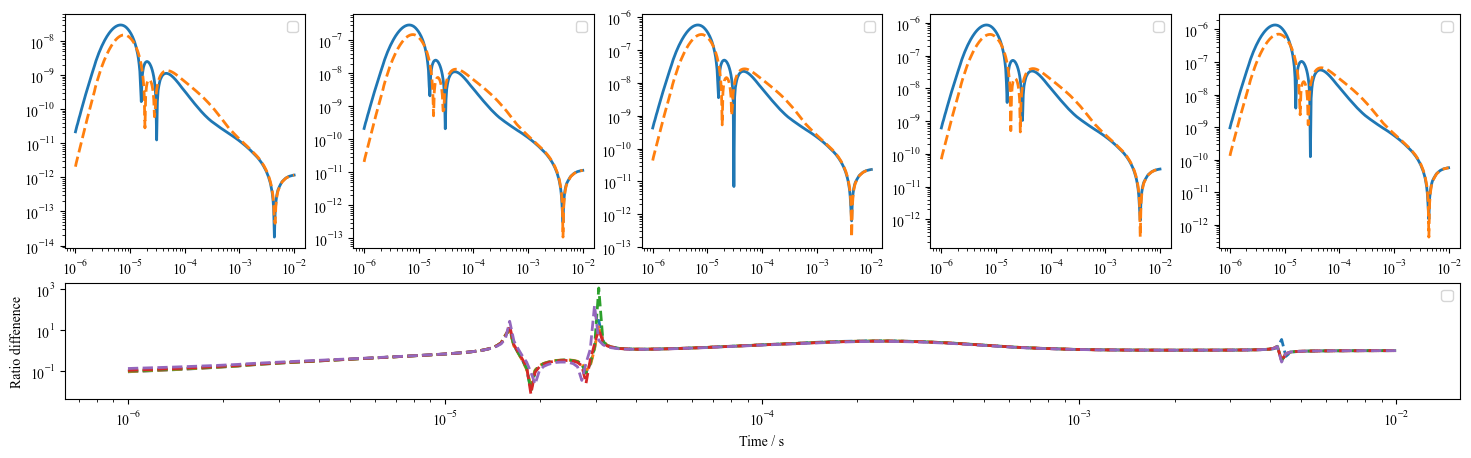

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 100
# sigma_frame = effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
# sigma_rail  = effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2]   # 异常体的方位
depth = [0, 0.5, 1, 2]

src_type = ['loop', 'line']
# src_type = ['loop']
distance = 150
loop_length = [2, 10, 20, 30, 50]
line_length = [2, 10, 20, 30, 50]
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)

Dobs = []
# for j in range(len(src_type)):
for j in range(len(loop_length)):
    dobs = []
    for i in range(len(sigma_block)):
        path = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m_2.npy".format(
            src_type[0],
            sigma_block[i], 
            loop_length[j],
            tunnel_length[0],
            dir[0],
            distance)
        dobs.append(np.load(path).reshape((3, times.shape[0])))
    Dobs.append(dobs)

fig = plt.figure(figsize=(18, 5), dpi=100)
font = 10
gs = gridspec.GridSpec(2, len(loop_length), height_ratios=[2, 1])  # 定义网格布局，第一行高度是第二行的三倍

syn = [ '-', '--', ':', '-.',   'o']
for i in range(len(loop_length)):
    # for j in range(3):
    ax = fig.add_subplot(gs[0, i])
    ax.loglog(times, np.abs(Dobs[i][0][1]), 'C{}{}'.format(0, syn[0]), lw=2)#, label = 'without abnormal')
    ax.loglog(times, np.abs(Dobs[i][1][1]), 'C{}{}'.format(1, syn[1]), lw=2)#, label = 'with abnormal')
    ax.legend(loc=1, fontsize=font)

error = []
for i in range(len(loop_length)):
    # for j in range(3):
    error.append(np.abs((Dobs[i][1][1] / Dobs[i][0][1])))
    # error_xyz.append(error)

ax = fig.add_subplot(gs[1, :])
for i in range(len(loop_length)):
    ax.loglog(times, error[i], 'C{}{}'.format(i, syn[1]), lw=2)
    ax.set_xlabel("Time / s", fontsize=font)
    
    ax.legend(loc=1, fontsize=font)
    if i == 0:
        ax.set_ylabel("Ratio diffenence", fontsize=font)

## Wire source

In [11]:
sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 100
sigma_frame = effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
sigma_rail  = effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2]   # 异常体的方位
depth = [0, 0.5, 1, 2]

src_type = ['loop', 'line']
# src_type = ['loop']
distance = 150
loop_length = [2, 10, 20, 30, 50]
# line_length = [2, 10, 20, 30, 50]
line_length = [2]

# for j in range(len(src_type)):
for j in range(len(line_length)):
    for i in range(len(sigma_block)):
        path = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m.npy".format(
            src_type[1],
            sigma_block[i], 
            line_length[j],
            tunnel_length[0],
            dir[0],
            distance)

        mesh, source_locations, receiver_locations, center = mesh_d(cell[0], tunnel_length[0], 
                                                                    depth[1], dir[0], distance, 
                                                                    line_length[j], loop_length[0], 
                                                                    src_type[1])
        model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, 
                                            sigma_rail, mu_r, sigma_block[i], 
                                            sigma_tunnel, center, tunnel_length[0], 
                                            distance)
        forward(mesh, model, mur, source_locations, receiver_locations, path, src_type[1])

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

### Without the influence of metal infractructures (Loop and Wire sources)

In [9]:
sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 1
sigma_frame = sigma_tunnel#effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
sigma_rail  = sigma_tunnel#effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2]   # 异常体的方位
depth = [0, 0.5, 1, 2]
src_length = [1, 5, 10, 20]
src_type = ['loop', 'line']
# src_type = ['line']
distance = 150
loop_length = 1

# for j in range(len(src_type)):
j = 1
for i in range(len(sigma_block)):
    path = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m_noInterference.npy".format(
        src_type[j],
        sigma_block[i], 
        src_length[0],
        tunnel_length[0],
        dir[0],
        distance)

    mesh, source_locations, receiver_locations, center = mesh_d(cell[0], tunnel_length[0], 
                                                                depth[1], dir[0], distance, 
                                                                src_length[0], src_length[0], 
                                                                src_type[j])
    model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, 
                                        sigma_rail, mu_r, sigma_block[i], 
                                        sigma_tunnel, center, tunnel_length[0], 
                                        distance)
    forward(mesh, model, mur, source_locations, receiver_locations, path, src_type[j])

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

### Plot fig.14

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


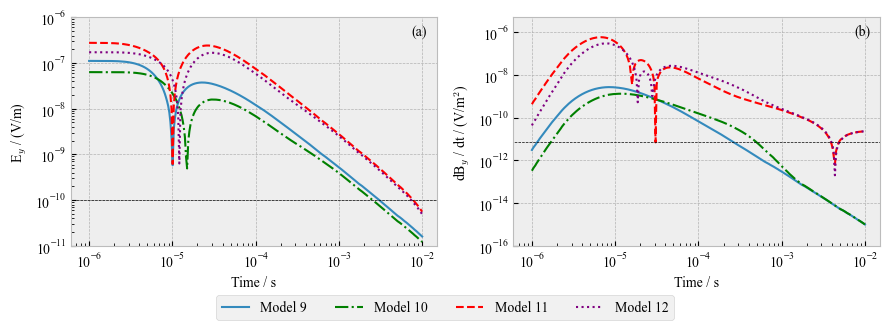

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

tunnel_length = [100, 200]

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2]   # 异常体的方位
depth = [0, 0.5, 1, 2]
src_length = [1, 5, 10, 20]
src_type = ['line','loop']
distance = 150
loop_length = 1
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)

Dobs = []
Dobs_n = []
for j in range(len(src_type)):
    dobs = []
    dobs_n = []
    for i in range(len(sigma_block)):
        path = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m.npy".format(
            src_type[j],
            sigma_block[i], 
            src_length[-1],
            tunnel_length[0],
            dir[0],
            distance)
        path2 = "./data_fig14_new/data_srcType[{}]_block{}_srcLen{}m_tunnel{}m_dir{}_distance{}m_noInterference.npy".format(
            src_type[j],
            sigma_block[i], 
            src_length[-1],
            tunnel_length[0],
            dir[0],
            distance)
        
        dobs.append(np.load(path).reshape((3, times.shape[0])))
        dobs_n.append(np.load(path2).reshape((3, times.shape[0])))
    Dobs.append(dobs)
    Dobs_n.append(dobs_n)

fig = plt.figure(figsize=(9, 3.2), dpi=100)
plt.rcParams["font.family"] = "Times New Roman"
font = 10
font1 = 8
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

linestyles = [ '-', '-.', '--', ':',    'o']
colors = ['C0', 'green', 'red', 'purple', 'orange', 'brown']
noise_level_loop = np.ones(times.shape[0]) * 7.5e-12
noise_level_wire = np.ones(times.shape[0]) * 1e-10

ax = fig.add_subplot(1, 2, 1)
ax.loglog(times, np.abs(Dobs_n[0][0][1]), color = colors[0], linestyle = linestyles[0], lw=1.5, label = 'Model 9')
ax.loglog(times, np.abs(Dobs_n[0][1][1]), color = colors[1], linestyle = linestyles[1],  lw=1.5, label = 'Model 10')

ax.loglog(times, np.abs(Dobs[0][0][1]), color = colors[2], linestyle = linestyles[2],  lw=1.5, label = 'Model 11')
ax.loglog(times, np.abs(Dobs[0][1][1]), color = colors[3], linestyle = linestyles[3],  lw=1.5, label = 'Model 12')
ax.loglog(noise_level_wire, 'k--', lw=0.5)
ax.set_xlim([6e-7, 1.5e-2])
ax.set_ylim([1e-11, 1e-6])
ax.text(0.93, 0.97, f"({chr(97+0)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
ax.set_xlabel('Time / s', fontsize=font)
ax.set_ylabel('E$_y$ / (V/m)', fontsize=font)
# ax.legend(loc=3, fontsize=font1)
# ax.grid(True, c="0.9")

# ax = fig.add_subplot(2, 2, 2)
# ax.loglog(times, np.abs(Dobs[0][0][1]), 'C{}{}'.format(0, syn[0]), lw=1.5, label = 'Without abnormal')
# ax.loglog(times, np.abs(Dobs[0][1][1]), 'C{}{}'.format(1, syn[1]), lw=1.5, label = 'With abnormal')
# ax.loglog(noise_level_wire, 'k--', lw=0.5)
# ax.set_xlim([6e-7, 1.5e-2])
# ax.set_ylim([1e-11, 1e-6])
# ax.text(0.88, 0.96, f"({chr(97+1)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
# ax.set_xlabel('Time / s', fontsize=font)
# ax.set_ylabel('E$_y$ / (V/m)', fontsize=font)
# ax.legend(loc=3, fontsize=font1)
# ax.grid(True, c="0.9")

ax = fig.add_subplot(1, 2, 2)
ax.loglog(times, np.abs(Dobs_n[1][0][1]), color = colors[0], linestyle = linestyles[0],  lw=1.5, label = 'Model 9')
ax.loglog(times, np.abs(Dobs_n[1][1][1]), color = colors[1], linestyle = linestyles[1],  lw=1.5, label = 'Model 10')

ax.loglog(times, np.abs(Dobs[1][0][1]), color = colors[2], linestyle = linestyles[2],  lw=1.5, label = 'Model 11')
ax.loglog(times, np.abs(Dobs[1][1][1]), color = colors[3], linestyle = linestyles[3],  lw=1.5, label = 'Model 12')
ax.loglog(noise_level_loop, 'k--', lw=0.5)
# ax.legend(loc=1, fontsize=font)
ax.set_xlim([6e-7, 1.5e-2])
ax.set_ylim([1e-16, 5e-6])
ax.text(0.93, 0.97, f"({chr(97+1)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
ax.set_xlabel('Time / s', fontsize=font)
ax.set_ylabel('dB$_y$ / dt / (V/m$^2$)', fontsize=font)
# ax.legend(loc=3, fontsize=font1)
# ax.grid(True, c="0.9")

# ax = fig.add_subplot(2, 2, 4)
# ax.loglog(times, np.abs(Dobs[1][0][1]), 'C{}{}'.format(0, syn[0]), lw=1.5, label = 'Without abnormal')
# ax.loglog(times, np.abs(Dobs[1][1][1]), 'C{}{}'.format(1, syn[1]), lw=1.5, label = 'With abnormal')
# ax.loglog(noise_level_loop, 'k--', lw=0.5)
# ax.set_xlim([6e-7, 1.5e-2])
# ax.set_ylim([1e-16, 5e-6])
# ax.text(0.88, 0.96, f"({chr(97+3)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
# ax.set_xlabel('Time / s', fontsize=font)
# ax.set_ylabel('dB / dt / (T/s)', fontsize=font)
# ax.legend(loc=3, fontsize=font1)
# ax.grid(True, c="0.9")

handles, labels = [], []
# for ax in fig.axes:
for handle, label in zip(*ax.get_legend_handles_labels()):
    handles.append(handle)
    labels.append(label)

fig.legend(handles, labels, loc='lower center',  bbox_to_anchor=(0.5, -0.04), ncol=6, fontsize=font)


plt.tight_layout(rect=[0, 0.03, 1, 1])  # 调整布局以给图例留出空间

plt.savefig('./figure14.eps', dpi=350, bbox_inches="tight")
plt.savefig('./figure14.png', dpi=350, bbox_inches="tight")
plt.savefig('./figure14.tiff', dpi=350, bbox_inches="tight")